# VideoMAE 8-Frame: Combined Mixup + Label Smoothing (Single Phase)

In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger('transformers').setLevel(logging.ERROR)

In [5]:
!uv pip install -q transformers accelerate

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


In [6]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from transformers import VideoMAEForVideoClassification, VideoMAEImageProcessor
from transformers import get_cosine_schedule_with_warmup
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gc

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

PATH_DATA_TRAIN = '/kaggle/input/action-video/data/data_train'
PATH_DATA_TEST = '/kaggle/input/action-video/data/test'

E0000 00:00:1768784095.904375      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768784095.954211      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Device: cuda


In [7]:
!gdown "1Xv2CWOqdBj3kt0rkNJKRsodSIEd3-wX_" -O test_labels.csv -q
gt_df = pd.read_csv("test_labels.csv")
TEST_LABELS = dict(zip(gt_df['id'].astype(str), gt_df['class']))
del gt_df; gc.collect()
print(f"Test labels: {len(TEST_LABELS)}")

Test labels: 510


## 1. Config

In [8]:
MODEL_CKPT = "MCG-NJU/videomae-base-finetuned-kinetics"
NUM_FRAMES = 8
IMG_SIZE = 224
RESIZE_SIZE = 256

# Single Phase Config
EPOCHS = 30
LR = 5e-5
LABEL_SMOOTHING = 0.1

BATCH_SIZE = 42
NUM_WORKERS = 4
WEIGHT_DECAY = 0.05
MIXUP_ALPHA = 0.8

print(f"Combined: Mixup(alpha={MIXUP_ALPHA}) + LabelSmoothing({LABEL_SMOOTHING})")
print(f"LR={LR}, BATCH={BATCH_SIZE}, EPOCHS={EPOCHS}")

Combined: Mixup(alpha=0.8) + LabelSmoothing(0.1)
LR=5e-05, BATCH=42, EPOCHS=30


## 2. Dataset

In [9]:
image_processor = VideoMAEImageProcessor.from_pretrained(MODEL_CKPT)
MEAN, STD = image_processor.image_mean, image_processor.image_std

class MixupCollateWithSmoothing:
    """Mixup + Label Smoothing combined"""
    def __init__(self, num_classes, alpha=0.8, smoothing=0.1):
        self.num_classes = num_classes
        self.alpha = alpha
        self.smoothing = smoothing
        
    def __call__(self, batch):
        inputs, targets = torch.utils.data.default_collate(batch)
        
        # Mixup
        lam = np.random.beta(self.alpha, self.alpha)
        idx = torch.randperm(inputs.size(0))
        inputs = lam * inputs + (1 - lam) * inputs[idx]
        
        # One-hot with Label Smoothing
        oh1 = F.one_hot(targets, self.num_classes).float()
        oh2 = F.one_hot(targets[idx], self.num_classes).float()
        
        # Apply label smoothing to both
        oh1 = oh1 * (1 - self.smoothing) + self.smoothing / self.num_classes
        oh2 = oh2 * (1 - self.smoothing) + self.smoothing / self.num_classes
        
        # Mixup the smoothed labels
        mixed_targets = lam * oh1 + (1 - lam) * oh2
        
        return inputs, mixed_targets

class VideoDataset(Dataset):
    def __init__(self, root, num_frames=8, is_train=True):
        self.root, self.num_frames, self.is_train = Path(root), num_frames, is_train
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.samples = [(list(sorted(v.glob('*.jpg'))), self.class_to_idx[c]) 
                        for c in self.classes for v in (self.root/c).iterdir() if v.is_dir()]
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        paths, label = self.samples[idx]
        indices = np.linspace(0, len(paths)-1, self.num_frames, dtype=int)
        frames = [TF.resize(Image.open(paths[i]).convert('RGB'), RESIZE_SIZE) for i in indices]
        if self.is_train:
            i,j,h,w = T.RandomResizedCrop.get_params(frames[0], (0.8,1.0), (0.75,1.33))
            flip = random.random() > 0.5
            frames = [TF.normalize(TF.to_tensor(TF.hflip(TF.resized_crop(f,i,j,h,w,(IMG_SIZE,IMG_SIZE))) if flip else TF.resized_crop(f,i,j,h,w,(IMG_SIZE,IMG_SIZE))), MEAN, STD) for f in frames]
        else:
            frames = [TF.normalize(TF.to_tensor(TF.center_crop(f, IMG_SIZE)), MEAN, STD) for f in frames]
        return torch.stack(frames), label

class TestDataset(Dataset):
    def __init__(self, root, num_frames=8):
        self.root, self.num_frames = Path(root), num_frames
        self.videos = sorted([d for d in self.root.iterdir() if d.is_dir()], key=lambda x: int(x.name))
    def __len__(self): return len(self.videos)
    def __getitem__(self, idx):
        v = self.videos[idx]
        paths = sorted(v.glob('*.jpg'))
        indices = np.linspace(0, len(paths)-1, self.num_frames, dtype=int)
        frames = [TF.normalize(TF.to_tensor(TF.center_crop(TF.resize(Image.open(paths[i]).convert('RGB'), RESIZE_SIZE), IMG_SIZE)), MEAN, STD) for i in indices]
        return torch.stack(frames), int(v.name)

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

In [10]:
train_dataset = VideoDataset(PATH_DATA_TRAIN, NUM_FRAMES, is_train=True)
test_dataset = TestDataset(PATH_DATA_TEST, NUM_FRAMES)
print(f"Train: {len(train_dataset)} | Test: {len(test_dataset)} | Classes: {len(train_dataset.classes)}")

# Combined collate function
combined_collate = MixupCollateWithSmoothing(len(train_dataset.classes), MIXUP_ALPHA, LABEL_SMOOTHING)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=combined_collate, drop_last=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

Train: 6254 | Test: 510 | Classes: 51


## 3. Model

In [11]:
model = VideoMAEForVideoClassification.from_pretrained(
    MODEL_CKPT, num_labels=len(train_dataset.classes), 
    ignore_mismatched_sizes=True, num_frames=NUM_FRAMES
).to(DEVICE)
print(f"Params: {sum(p.numel() for p in model.parameters()):,}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Params: 86,266,419


## 4. Training Functions

In [12]:
def train_epoch(model, loader, optimizer, scheduler, scaler):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    
    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        
        with torch.amp.autocast('cuda'):
            logits = model(x).logits
            # Soft cross entropy (for mixed + smoothed labels)
            loss = -torch.sum(y * F.log_softmax(logits, 1), 1).mean()
            labels = y.argmax(1)
        
        total_loss += loss.item()
        correct += (logits.argmax(1) == labels).sum().item()
        total += x.size(0)
        
        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        del x, y, logits, loss
    
    return total_loss / len(loader), correct / total

@torch.no_grad()
def evaluate(model, loader, classes):
    model.eval()
    all_preds, all_ids = [], []
    
    for x, ids in tqdm(loader, desc="Eval", leave=False):
        x = x.to(DEVICE, non_blocking=True)
        preds = model(x).logits.argmax(1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_ids.extend(ids.numpy().tolist())
        del x, preds
    
    y_pred = [classes[p] for vid, p in zip(all_ids, all_preds) if str(vid) in TEST_LABELS]
    y_true = [TEST_LABELS[str(vid)] for vid in all_ids if str(vid) in TEST_LABELS]
    return accuracy_score(y_true, y_pred)

def save_checkpoint(epoch, loss, train_acc, test_acc, best_acc):
    torch.save(model.state_dict(), 'checkpoint.pt')
    row = {'epoch': epoch, 'loss': loss, 'train_acc': train_acc, 'test_acc': test_acc, 'best_acc': best_acc}
    df = pd.DataFrame([row])
    if os.path.exists('history.csv'):
        df.to_csv('history.csv', mode='a', header=False, index=False)
    else:
        df.to_csv('history.csv', index=False)
    print(f"  Loss:{loss:.4f} | Train:{train_acc:.4f} | Test:{test_acc:.4f} | Best:{best_acc:.4f}")

## 5. Check Resume

In [13]:
START_EPOCH = 1
best_acc = 0

if os.path.exists('history.csv') and os.path.exists('checkpoint.pt'):
    df = pd.read_csv('history.csv')
    last = df.iloc[-1]
    model.load_state_dict(torch.load('checkpoint.pt', map_location=DEVICE))
    START_EPOCH = int(last['epoch']) + 1
    best_acc = float(last['best_acc'])
    print(f"✅ Resume from epoch {START_EPOCH}, best={best_acc:.4f}")
else:
    print("📝 Starting fresh")

📝 Starting fresh


## 6. Training (Single Phase: Mixup + Label Smoothing)

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_cosine_schedule_with_warmup(optimizer, int(total_steps*0.1), total_steps)

# Fast-forward scheduler if resuming
for _ in range((START_EPOCH - 1) * len(train_loader)):
    scheduler.step()

scaler = torch.amp.GradScaler()

print("="*60)
print(f"SINGLE PHASE: Mixup + LabelSmoothing | LR={LR} | Epochs {START_EPOCH}-{EPOCHS}")
print("="*60)

for ep in range(START_EPOCH, EPOCHS + 1):
    print(f"\nEpoch {ep}/{EPOCHS}")
    loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, scaler)
    test_acc = evaluate(model, test_loader, train_dataset.classes)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({'model': model.state_dict(), 'classes': train_dataset.classes}, 'best.pt')
        print(f"  >>> New Best!")
    
    save_checkpoint(ep, loss, train_acc, test_acc, best_acc)
    gc.collect(); torch.cuda.empty_cache()

print(f"\n🏆 FINAL BEST: {best_acc:.4f}")

SINGLE PHASE: Mixup + LabelSmoothing | LR=5e-05 | Epochs 1-30

Epoch 1/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:3.7898 | Train:0.0869 | Test:0.2471 | Best:0.2471

Epoch 2/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:2.8498 | Train:0.5043 | Test:0.6431 | Best:0.6431

Epoch 3/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:2.1078 | Train:0.7120 | Test:0.7392 | Best:0.7392

Epoch 4/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:1.8747 | Train:0.7661 | Test:0.7549 | Best:0.7549

Epoch 5/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:1.7185 | Train:0.7952 | Test:0.7627 | Best:0.7627

Epoch 6/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:1.6586 | Train:0.8111 | Test:0.7843 | Best:0.7843

Epoch 7/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:1.5146 | Train:0.8700 | Test:0.8059 | Best:0.8059

Epoch 8/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.4940 | Train:0.8604 | Test:0.7961 | Best:0.8059

Epoch 9/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.4857 | Train:0.8581 | Test:0.7784 | Best:0.8059

Epoch 10/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.4965 | Train:0.8414 | Test:0.8000 | Best:0.8059

Epoch 11/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.4772 | Train:0.8457 | Test:0.7882 | Best:0.8059

Epoch 12/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.4205 | Train:0.8629 | Test:0.8020 | Best:0.8059

Epoch 13/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.4384 | Train:0.8625 | Test:0.8020 | Best:0.8059

Epoch 14/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.3716 | Train:0.8779 | Test:0.8039 | Best:0.8059

Epoch 15/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.3280 | Train:0.9040 | Test:0.8000 | Best:0.8059

Epoch 16/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:1.3597 | Train:0.8671 | Test:0.8157 | Best:0.8157

Epoch 17/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.3997 | Train:0.8481 | Test:0.8020 | Best:0.8157

Epoch 18/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:1.3104 | Train:0.9009 | Test:0.8176 | Best:0.8176

Epoch 19/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.3482 | Train:0.8814 | Test:0.8157 | Best:0.8176

Epoch 20/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.3029 | Train:0.8790 | Test:0.8157 | Best:0.8176

Epoch 21/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.2856 | Train:0.8900 | Test:0.8157 | Best:0.8176

Epoch 22/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.2968 | Train:0.8969 | Test:0.8176 | Best:0.8176

Epoch 23/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:1.2596 | Train:0.9038 | Test:0.8196 | Best:0.8196

Epoch 24/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:1.2670 | Train:0.8983 | Test:0.8235 | Best:0.8235

Epoch 25/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:1.2798 | Train:0.8986 | Test:0.8275 | Best:0.8275

Epoch 26/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.2340 | Train:0.9078 | Test:0.8275 | Best:0.8275

Epoch 27/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.2661 | Train:0.8958 | Test:0.8235 | Best:0.8275

Epoch 28/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.2828 | Train:0.8800 | Test:0.8255 | Best:0.8275

Epoch 29/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:1.2783 | Train:0.9134 | Test:0.8294 | Best:0.8294

Epoch 30/30


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:1.2744 | Train:0.9109 | Test:0.8275 | Best:0.8294

🏆 FINAL BEST: 0.8294


## 7. Plot

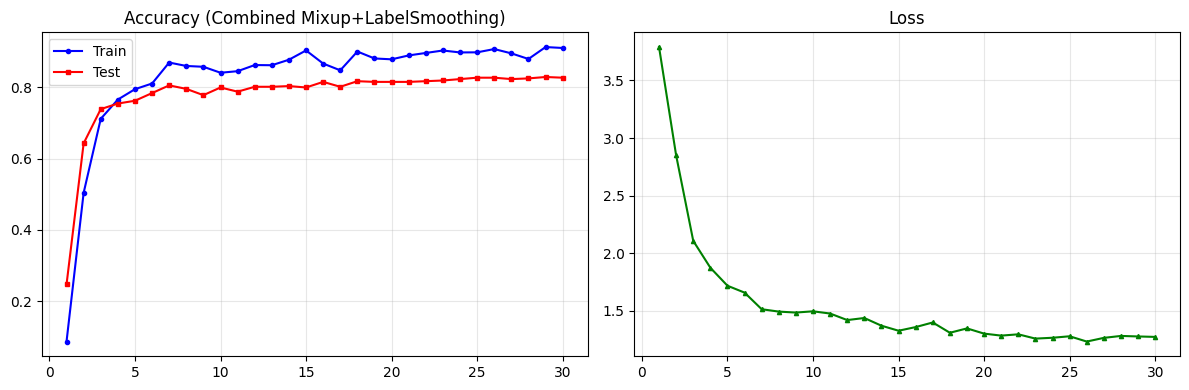

 epoch     loss  train_acc  test_acc  best_acc
     1 3.789832   0.086873  0.247059  0.247059
     2 2.849825   0.504344  0.643137  0.643137
     3 2.107813   0.712033  0.739216  0.739216
     4 1.874682   0.766088  0.754902  0.754902
     5 1.718467   0.795206  0.762745  0.762745
     6 1.658647   0.811133  0.784314  0.784314
     7 1.514605   0.870013  0.805882  0.805882
     8 1.493956   0.860360  0.796078  0.805882
     9 1.485656   0.858108  0.778431  0.805882
    10 1.496498   0.841377  0.800000  0.805882
    11 1.477223   0.845721  0.788235  0.805882
    12 1.420479   0.862934  0.801961  0.805882
    13 1.438400   0.862452  0.801961  0.805882
    14 1.371558   0.877896  0.803922  0.805882
    15 1.328010   0.903958  0.800000  0.805882
    16 1.359658   0.867117  0.815686  0.815686
    17 1.399690   0.848134  0.801961  0.815686
    18 1.310425   0.900901  0.817647  0.817647
    19 1.348212   0.881435  0.815686  0.817647
    20 1.302893   0.879022  0.815686  0.817647
    21 1.2855

In [15]:
if os.path.exists('history.csv'):
    df = pd.read_csv('history.csv')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(df['epoch'], df['train_acc'], 'b-o', label='Train', ms=3)
    axes[0].plot(df['epoch'], df['test_acc'], 'r-s', label='Test', ms=3)
    axes[0].set_title('Accuracy (Combined Mixup+LabelSmoothing)'); axes[0].legend(); axes[0].grid(alpha=0.3)
    axes[1].plot(df['epoch'], df['loss'], 'g-^', ms=3)
    axes[1].set_title('Loss'); axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('curves.png', dpi=150)
    plt.show()
    print(df.to_string(index=False))